In [1]:
import pandas as pd

Shape of X: (150, 4)
Shape of transformed X: (150, 2)


C:\Users\DELL\AppData\Local\Temp\ipykernel_6132\4098609510.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  x1, x2, c=y, edgecolor="none", alpha=0.8, cmap=plt.cm.get_cmap("viridis", 3)


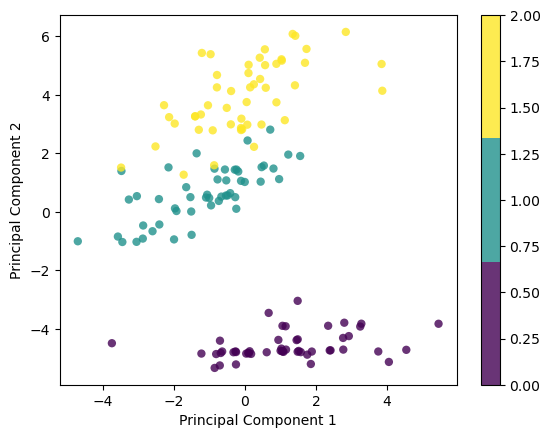

In [2]:
import numpy as np


class PCA:

    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None

    def fit(self, X):
        # mean centering
        self.mean = np.mean(X, axis=0)
        X = X -  self.mean

        # covariance, functions needs samples as columns
        cov = np.cov(X.T)

        # eigenvectors, eigenvalues
        eigenvectors, eigenvalues = np.linalg.eig(cov)

        # eigenvectors v = [:, i] column vector, transpose this for easier calculations
        eigenvectors = eigenvectors.T

        # sort eigenvectors
        idxs = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]

        self.components = eigenvectors[:self.n_components]

    def transform(self, X):
        # projects data
        X = X - self.mean
        return np.dot(X, self.components.T)


# Testing
if __name__ == "__main__":
    # Imports
    import matplotlib.pyplot as plt
    from sklearn import datasets

    # data = datasets.load_digits()
    data = datasets.load_iris()
    X = data.data
    y = data.target

    # Project the data onto the 2 primary principal components
    pca = PCA(2)
    pca.fit(X)
    X_projected = pca.transform(X)

    print("Shape of X:", X.shape)
    print("Shape of transformed X:", X_projected.shape)

    x1 = X_projected[:, 0]
    x2 = X_projected[:, 1]

    plt.scatter(
        x1, x2, c=y, edgecolor="none", alpha=0.8, cmap=plt.cm.get_cmap("viridis", 3)
    )

    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.colorbar()
    plt.show()

In [3]:
import numpy as np
from collections import Counter


class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None


class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

    
        if (depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

       
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feature, best_thresh, left, right)


    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
          
                gain = self._information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold


    def _information_gain(self, y, X_column, threshold):
       
        parent_entropy = self._entropy(y)

       
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        
       
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r

    
        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log(p) for p in ps if p>0])


    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)
        



In [5]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# Load breast cancer dataset
data = datasets.load_breast_cancer()
X, y = data.data, data.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234
)

# Create a Decision Tree classifier with a maximum depth of 10
clf = DecisionTreeClassifier(max_depth=10)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
predictions = clf.predict(X_test)

# Calculate accuracy
def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)

acc = accuracy(y_test, predictions)
print("Accuracy:", acc)


Accuracy: 0.9035087719298246


In [2]:
df=pd.read_csv(r'D:\machine learning dataset\train and test.csv')

In [3]:
df

,Age,premium
0,25,18000
1,30,32000
2,35,40000
3,40,47000
4,45,55000


In [4]:
x=df['Age']

In [5]:
y=df['premium']

In [6]:
x

0    25
1    30
2    35
3    40
4    45
Name: Age, dtype: int64

In [7]:
y

0    18000
1    32000
2    40000
3    47000
4    55000
Name: premium, dtype: int64

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

In [10]:
x_train

3    40
0    25
2    35
1    30
Name: Age, dtype: int64

In [11]:
x_test

4    45
Name: Age, dtype: int64

In [12]:
y_train

3    47000
0    18000
2    40000
1    32000
Name: premium, dtype: int64

In [13]:
y_test

4    55000
Name: premium, dtype: int64

In [14]:
len(y_test)

1

In [15]:
len(y_train)

4

# Linear Equation
# Term Insurance Dataset

In [16]:
import pandas as pd 
import seaborn as sns 
from sklearn import linear_model 
import matplotlib.pyplot as plt



In [17]:
df=pd.read_csv(r'D:\machine learning dataset\train and test.csv')

In [18]:
df

,Age,premium
0,25,18000
1,30,32000
2,35,40000
3,40,47000
4,45,55000


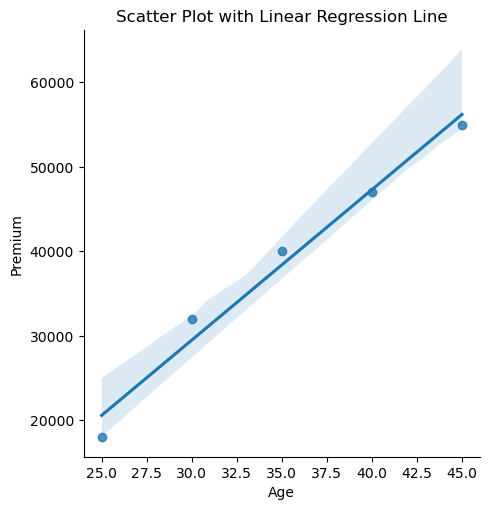

In [19]:
sns.lmplot(x='Age', y='premium', data=df)
plt.title('Scatter Plot with Linear Regression Line')
plt.xlabel('Age')
plt.ylabel('Premium')
plt.show()

In [20]:
reg=linear_model.LinearRegression()

In [21]:
reg.fit(df[['Age']],df['premium'])

LinearRegression()

In [22]:
reg.predict([[21]])

C:\ProgramData\anaconda3\anaconda\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([13480.])

In [23]:
reg.predict([[50]])

C:\ProgramData\anaconda3\anaconda\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([65100.])

In [24]:
reg.coef_

array([1780.])

In [25]:
reg.intercept_

-23899.999999999985

# Linear Regression Multiple variable

In [26]:
import pandas as pd 
import seaborn as sns 
from sklearn import linear_model 
import matplotlib.pyplot as plt


In [27]:
df=pd.read_csv(r'D:\machine learning dataset\training.csv')

In [28]:
df

,Age,height,weight,premium
0,25,162.56,70,18000
1,30,172.72,95,32000
2,35,167.64,78,40000
3,40,NaN,110,47000
4,45,157.48,85,55000


In [29]:
mean_height=df.height.mean()

In [30]:
df.height=df.height.fillna(mean_height)

In [31]:
df

,Age,height,weight,premium
0,25,162.56,70,18000
1,30,172.72,95,32000
2,35,167.64,78,40000
3,40,165.10,110,47000
4,45,157.48,85,55000


In [32]:
reg=linear_model.LinearRegression()

In [33]:
reg.fit(df[['Age','height','weight']],df['premium'])

LinearRegression()

In [34]:
reg.coef_

array([2009.46501319,  501.71220028,  -56.72906086])

In [35]:
reg.intercept_

-109794.49399687728

In [36]:
reg.predict([[27,167.56,60]])

C:\ProgramData\anaconda3\anaconda\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([25124.21398681])

In [37]:
reg.predict([[60,165.10,80]])

C:\ProgramData\anaconda3\anaconda\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([89067.76619228])

# Polynomial Regression

In [38]:
import pandas as pd 
import seaborn as sns 
from sklearn import linear_model 
import matplotlib.pyplot as plt

In [39]:
dataset=pd.read_csv(r'D:\machine learning dataset\Polynomial Regression.csv')

In [40]:
dataset

,Position,level,Salary
0,Business Analyst,1,45000
1,Junior Consultant,2,50000
2,Senior Consultant,3,60000
3,Manager,4,80000
4,Country Manager,5,110000
5,Region Manager,6,150000
6,Partner,7,200000
7,Senior Partner,8,300000
8,C-level,9,500000
9,CEO,10,1000000


In [41]:
x=dataset.iloc[:,1:2].values

In [42]:
x

array([[ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10]], dtype=int64)

In [43]:
y=dataset.iloc[:,2].values

In [44]:
y

array([  45000,   50000,   60000,   80000,  110000,  150000,  200000,
        300000,  500000, 1000000], dtype=int64)

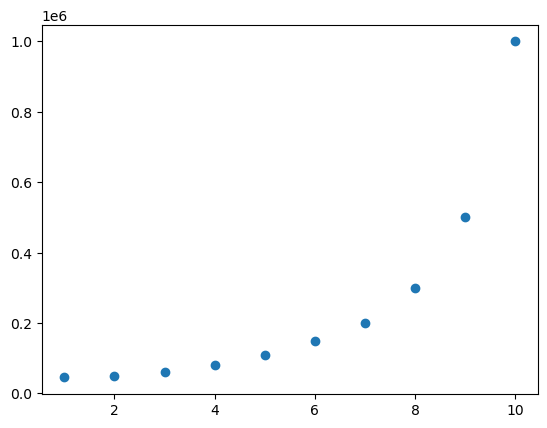

In [45]:
plt.scatter(x,y)

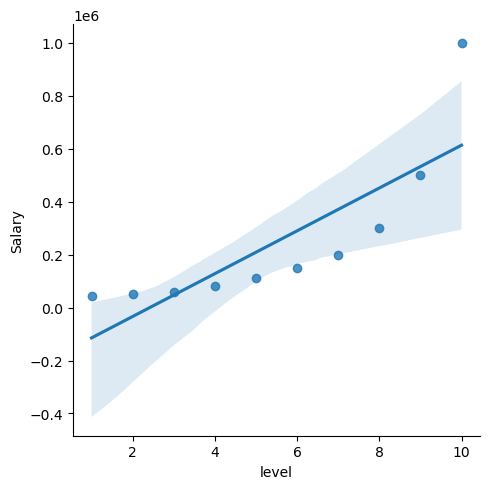

In [46]:
sns.lmplot(x='level',y='Salary',data=dataset)


In [47]:
from sklearn import linear_model

In [48]:
reg=linear_model.LinearRegression()

In [49]:
reg.fit(x,y)

LinearRegression()

In [50]:
reg.predict([[6.5]])

array([330378.78787879])

In [51]:
from sklearn.preprocessing import PolynomialFeatures

In [52]:
poly=PolynomialFeatures(degree=2)

In [53]:
x_poly=poly.fit_transform(x)

In [54]:
reg2=linear_model.LinearRegression()

In [55]:
reg2.fit(x_poly,y)

LinearRegression()

In [56]:
reg2.predict(poly.fit_transform([[6.5]]))

array([189498.10606061])

# dependent vairiable is purchased

In [57]:
import numpy as np
import pandas as pd

In [58]:
dataset=pd.read_csv(r"D:\machine learning dataset\ml project.csv")

In [59]:
dataset

,Country,Age,Salary,Purchased
0,France,44.0,72000.0,No
1,Spain,27.0,48000.0,Yes
2,Germany,30.0,54000.0,No
3,Spain,38.0,61000.0,No
4,Germany,40.0,NaN,Yes
5,France,35.0,58000.0,Yes
6,Spain,NaN,52000.0,No
7,France,48.0,79000.0,Yes
8,Germany,50.0,83000.0,No
9,France,37.0,67000.0,Yes


In [60]:
x=dataset[['Country','Age','Salary']].values

In [61]:
y=dataset[['Purchased']].values

In [62]:
y

array([['No'],
       ['Yes'],
       ['No'],
       ['No'],
       ['Yes'],
       ['Yes'],
       ['No'],
       ['Yes'],
       ['No'],
       ['Yes']], dtype=object)

In [63]:
from sklearn.impute import SimpleImputer

In [64]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

In [65]:
imputer=imputer.fit(x[:,1:3])

In [66]:
x[:,1:3]=imputer.transform(x[:,1:3])

In [67]:
x

array([['France', 44.0, 72000.0],
       ['Spain', 27.0, 48000.0],
       ['Germany', 30.0, 54000.0],
       ['Spain', 38.0, 61000.0],
       ['Germany', 40.0, 63777.77777777778],
       ['France', 35.0, 58000.0],
       ['Spain', 38.77777777777778, 52000.0],
       ['France', 48.0, 79000.0],
       ['Germany', 50.0, 83000.0],
       ['France', 37.0, 67000.0]], dtype=object)

In [68]:
from sklearn.preprocessing import LabelEncoder

In [69]:
Label_encoder_x=LabelEncoder()

In [70]:
x[:,0]=Label_encoder_x.fit_transform(x[:,0])

In [71]:
x

array([[0, 44.0, 72000.0],
       [2, 27.0, 48000.0],
       [1, 30.0, 54000.0],
       [2, 38.0, 61000.0],
       [1, 40.0, 63777.77777777778],
       [0, 35.0, 58000.0],
       [2, 38.77777777777778, 52000.0],
       [0, 48.0, 79000.0],
       [1, 50.0, 83000.0],
       [0, 37.0, 67000.0]], dtype=object)

In [72]:
from sklearn.preprocessing import OneHotEncoder

In [73]:
onehotencoder= OneHotEncoder()

In [74]:
x=onehotencoder.fit_transform(dataset.Country.values.reshape(-1,1)).toarray()

In [75]:
x

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [76]:
label_encoder_y=LabelEncoder()

In [77]:
y=label_encoder_y.fit_transform(y)

C:\ProgramData\anaconda3\anaconda\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [78]:
y

array([0, 1, 0, 0, 1, 1, 0, 1, 0, 1])

In [79]:
from sklearn.model_selection import train_test_split

In [80]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

In [81]:
x_train

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [82]:
x_test

array([[0., 1., 0.],
       [0., 1., 0.]])

In [83]:
y_train

array([1, 1, 1, 0, 1, 0, 0, 1])

In [84]:
y_test

array([0, 0])

In [85]:
from sklearn.preprocessing import StandardScaler

In [86]:
sc_x=StandardScaler()

In [87]:
x_train=sc_x.fit_transform(x_train)

In [88]:
x_test=sc_x.transform(x_test)

In [89]:
x_train

array([[-1.        ,  2.64575131, -0.77459667],
       [ 1.        , -0.37796447, -0.77459667],
       [-1.        , -0.37796447,  1.29099445],
       [-1.        , -0.37796447,  1.29099445],
       [ 1.        , -0.37796447, -0.77459667],
       [-1.        , -0.37796447,  1.29099445],
       [ 1.        , -0.37796447, -0.77459667],
       [ 1.        , -0.37796447, -0.77459667]])

In [90]:
x_test

array([[-1.        ,  2.64575131, -0.77459667],
       [-1.        ,  2.64575131, -0.77459667]])

# Logistic Regression Real Life Example

# Heart Attact prediction Tumour predction
# Credit card Fraud 

In [91]:
import pandas as pd  
import matplotlib.pyplot as plt

In [92]:
dataset=pd.read_csv(r"C:\Users\DELL\Downloads\logistic\insurance_data.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\DELL\\Downloads\\logistic\\insurance_data.csv'

In [ ]:
dataset

In [ ]:
dataset['bought_insurance'].replace({'no':'0','yes':'1'},inplace=True)

In [ ]:
dataset

In [ ]:
plt.scatter(x='age',y='bought_insurance',data=dataset)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(dataset[['age']],dataset['bought_insurance'],test_size=0.2)

In [ ]:
len(x_train)

In [ ]:
len(x_test)

In [ ]:
x_test

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr=LogisticRegression()

In [ ]:
lr.fit(x_train,y_train)

In [ ]:
lr.predict(x_test)

In [ ]:
lr.predict([[60]])

In [ ]:
lr.predict([[23]])

# logistic Regression multiple classification

# Logistic Regression is a ML algorithm based on supervised learning. It is a statistical method that is used for predicting probability of target variable.Logistic Regression makes probability for classification problems that are discrete in nature.
# Example:-English or Hindi, True or False,0 or 1

In [ ]:
import numpy as np
import pandas as pd 
from pandas import Series, DataFrame

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
dataset=pd.read_csv(r"D:\machine learning dataset\Logistic 2\Iris.csv")

In [ ]:
dataset

In [ ]:
dataset.info()

In [ ]:
dataset['Species'].unique()

In [ ]:
dataset['Species'].replace({'Iris-setosa':'1','Iris-versicolor':'2','Iris-virginica':'3'},inplace=True)

In [ ]:
dataset

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    dataset[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']],
    dataset['Species'],
    test_size=0.2
)

In [ ]:
len(x_train)

In [ ]:
len(x_test)

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr=LogisticRegression()

In [ ]:
lr.fit(x_train,y_train)

In [ ]:
lr.predict(x_test)

In [ ]:
x_test

In [ ]:
lr.score(x_test,y_test)

In [ ]:
import seaborn as sns

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have imported the necessary libraries and have your dataset ready

sns.pairplot(dataset[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species']], hue='Species')
plt.show()


# Decision Tree classification in ML

In [1]:
import pandas as pd 
data=pd.read_csv(r"D:\machine learning dataset\IDE3.csv")

In [2]:
data

,Outlook,Humidity,Windy,Play
0,Sunny,High,Weak,No
1,Sunny,High,Strong,No
2,Overcast,High,Weak,Yes
3,Rain,High,Weak,Yes
4,Rain,Normal,Weak,Yes
5,Rain,Normal,Strong,No
6,Overcast,Normal,Strong,Yes
7,Sunny,High,Weak,No
8,Sunny,Normal,Weak,Yes
9,Rain,Normal,Weak,Yes


In [3]:
from sklearn.preprocessing import LabelEncoder

In [4]:
Outlook=LabelEncoder()
Humidity=LabelEncoder()
Windy=LabelEncoder()
Play=LabelEncoder()

In [5]:
data['Outlook']=Outlook.fit_transform(data['Outlook'])
data['Humidity']=Humidity.fit_transform(data['Humidity'])
data['Windy']=Windy.fit_transform(data['Windy'])
data['Play']=Play.fit_transform(data['Play'])

In [6]:
data

,Outlook,Humidity,Windy,Play
0,2,0,1,0
1,2,0,0,0
2,0,0,1,1
3,1,0,1,1
4,1,1,1,1
5,1,1,0,0
6,0,1,0,1
7,2,0,1,0
8,2,1,1,1
9,1,1,1,1


In [7]:
features_cols=['Outlook','Humidity','Windy']
x=data[features_cols]
y=data.Play

In [8]:
x

,Outlook,Humidity,Windy
0,2,0,1
1,2,0,0
2,0,0,1
3,1,0,1
4,1,1,1
5,1,1,0
6,0,1,0
7,2,0,1
8,2,1,1
9,1,1,1


In [9]:
y

0     0
1     0
2     1
3     1
4     1
5     0
6     1
7     0
8     1
9     1
10    1
11    1
12    1
13    0
Name: Play, dtype: int32

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

In [12]:
from sklearn.tree import DecisionTreeClassifier

In [13]:
classifier=DecisionTreeClassifier(criterion='gini')

In [14]:
classifier.fit(x_train,y_train)

DecisionTreeClassifier()

In [15]:
classifier.predict(x_test)

array([1, 1, 1])

In [16]:
x_test # 0 no ,1 yes ,outlook=summy 2

,Outlook,Humidity,Windy
12,0,1,1
5,1,1,0
13,1,0,0


In [17]:
classifier.score(x_test,y_test)

0.3333333333333333

[Text(0.4, 0.8333333333333334, 'x[0] <= 1.5\ngini = 0.397\nsamples = 11\nvalue = [3, 8]'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 6\nvalue = [0, 6]'),
 Text(0.6, 0.5, 'x[1] <= 0.5\ngini = 0.48\nsamples = 5\nvalue = [3, 2]'),
 Text(0.4, 0.16666666666666666, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]')]

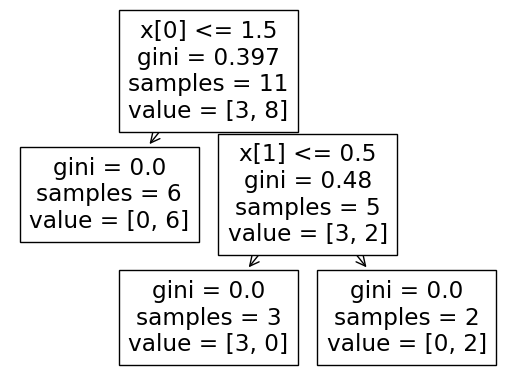

In [18]:
from sklearn import tree
tree.plot_tree(classifier)

# Random forest Algorithm 

In [ ]:
import numpy as np
import pandas as pd 
from pandas import Series, DataFrame

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
iris = pd.read_csv(r"D:\machine learning dataset\Logistic 2\Iris.csv")

In [ ]:
iris.head()

In [ ]:
iris.info()

# removing unneeded column

In [ ]:
iris.drop("Id", axis=1, inplace = True)

# Some EDA with Iris

In [ ]:
fig = iris[iris.Species == 'Iris-setosa'].plot(kind='scatter', x='SepalLengthCm', y='SepalWidthCm', color='orange', label='Setosa')
iris[iris.Species == 'Iris-versicolor'].plot(kind='scatter', x='SepalLengthCm', y='SepalWidthCm', color='blue', label='Versicolor', ax=fig)
iris[iris.Species == 'Iris-virginica'].plot(kind='scatter', x='SepalLengthCm', y='SepalWidthCm', color='green', label='Virginica', ax=fig)

fig.set_xlabel('Sepal Length')
fig.set_ylabel('Sepal Width')
fig.set_title('Sepal Length Vs Width')

fig=plt.gcf()
fig.set_size_inches(10, 7)
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

# Load the Iris dataset
iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['Species'] = iris.target_names[iris.target]

# Create a FacetGrid scatter plot
g = sns.FacetGrid(iris_df, hue='Species', height=5)
g.map(plt.scatter, 'sepal length (cm)', 'sepal width (cm)').add_legend()

# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_iris

# Load the Iris dataset
iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['Species'] = iris.target_names[iris.target]

# Create a scatter plot
fig, ax = plt.subplots(figsize=(10, 7))

iris_df[iris_df['Species'] == 'setosa'].plot(
    kind='scatter', x='petal length (cm)', y='petal width (cm)',
    color='orange', label='Setosa', ax=ax
)

iris_df[iris_df['Species'] == 'versicolor'].plot(
    kind='scatter', x='petal length (cm)', y='petal width (cm)',
    color='blue', label='Versicolor', ax=ax
)

iris_df[iris_df['Species'] == 'virginica'].plot(
    kind='scatter', x='petal length (cm)', y='petal width (cm)',
    color='green', label='Virginica', ax=ax
)

ax.set_xlabel('Petal Length')
ax.set_ylabel('Petal Width')
ax.set_title('Petal Length Vs Width')

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_iris

# Load the Iris dataset
iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)

# Create histograms for each feature
iris_df.hist(edgecolor='black', linewidth=1.2, figsize=(12, 6))

# Set the title for the entire histogram plot
plt.suptitle('Histograms of Iris Dataset Features', fontsize=16)

# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.datasets import load_iris

# Load the Iris dataset
iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['Species'] = iris.target_names[iris.target]

# Create a 2x2 grid of violin plots
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.violinplot(x='Species', y='sepal length (cm)', data=iris_df)

plt.subplot(2, 2, 2)
sns.violinplot(x='Species', y='sepal width (cm)', data=iris_df)

plt.subplot(2, 2, 3)
sns.violinplot(x='Species', y='petal length (cm)', data=iris_df)

plt.subplot(2, 2, 4)
sns.violinplot(x='Species', y='petal width (cm)', data=iris_df)

plt.show()


In [ ]:
# importing alll the necessary packages to use the various classification algorithms
from sklearn.linear_model import LogisticRegression # for Logistic Regression Algorithm
from sklearn.model_selection import train_test_split # to split the dataset for training and testing 
from sklearn.neighbors import KNeighborsClassifier # KNN classifier
from sklearn import svm # for suport vector machine algorithm
from sklearn import metrics # for checking the model accuracy
from sklearn.tree import DecisionTreeClassifier # for using DTA

In [ ]:
from sklearn.datasets import load_iris

# Load the Iris dataset
iris = load_iris()

# Check the shape
print(iris.data.shape)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
import pandas as pd

# Load the Iris dataset
iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)

# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 4))
sns.heatmap(iris_df.corr(), annot=True, cmap='cubehelix_r')

# Show the heatmap
plt.show()


# Splitting The Data into Training And Testing Dataset

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Load the Iris dataset
iris = load_iris()
X = iris.data  # Features
y = iris.target  # Target labels

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)


In [ ]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Load the Iris dataset
iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['Species'] = iris.target_names[iris.target]

# Split the data into training and testing sets
X = iris_df[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']]
y = iris_df['Species']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Now you have the training and testing sets
train_X = X_train
train_y = y_train
test_X = X_test
test_y = y_test


In [ ]:
train_X.head()

In [ ]:
test_X.head()

In [ ]:
train_y.head()

# Support Vector Machine SVM

In [ ]:
model = svm.SVC() # select the svm algorithm

# we train the algorithm with training data and training output
model.fit(train_X, train_y)

# we pass the testing data to the stored algorithm to predict the outcome
prediction = model.predict(test_X)
print('The accuracy of the SVM is: ', metrics.accuracy_score(prediction, test_y)) # we check the accuracy of the algorithm
#we pass the predicted output by the model and the actual output

# Logistic Regression

In [ ]:
model = LogisticRegression()
model.fit(train_X, train_y)
prediction = model.predict(test_X)
print('The accuracy of Logistic Regression is: ', metrics.accuracy_score(prediction, test_y))

# Decision Tree

In [ ]:
model = DecisionTreeClassifier()
model.fit(train_X, train_y)
prediction = model.predict(test_X)
print('The accuracy of Decision Tree is: ', metrics.accuracy_score(prediction, test_y))

# K-Nearest Neighbors

In [ ]:
model = KNeighborsClassifier(n_neighbors=3) # this examines 3 neighbors for putting the data into class
model.fit(train_X, train_y)
prediction = model.predict(test_X)
print('The accuracy of KNN is: ', metrics.accuracy_score(prediction, test_y))

# Let's check the accuracy for various values of n for K-Nearest nerighbours

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# Load the Iris dataset
iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['Species'] = iris.target_names[iris.target]

# Split the data into training and testing sets
X = iris_df[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']]
y = iris_df['Species']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize lists to store accuracy values and the corresponding values of n_neighbors
a_index = list(range(1, 11))
a = []

# Calculate accuracy for different values of n_neighbors
for i in a_index:
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    accuracy = metrics.accuracy_score(prediction, y_test)
    a.append(accuracy)

# Convert the list to a Pandas Series
a = pd.Series(a)

# Plot the accuracy values
plt.plot(a_index, a)
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.xticks(x)
plt.xlabel("Number of Neighbors (n_neighbors)")
plt.ylabel("Accuracy")
plt.title("K-Nearest Neighbors Classifier Accuracy")
plt.show()



# Naive bayes classifier 

In [ ]:
import pandas as pd 

In [ ]:
dataset=pd.read_csv(r'D:\machine learning dataset\Naive bayes classifier\Social_Network_Ads.csv')

In [ ]:
dataset # advertisment ke through puchased karne ka link aata hai ki aap mera add kariye 

In [ ]:
x=dataset.iloc[:,[1,2,3]].values

In [ ]:
x

In [ ]:
y=dataset.iloc[:,-1].values

In [ ]:
y # iloc array ke liye use hota hai

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
le=LabelEncoder()

In [ ]:
x[:,0]=le.fit_transform(x[:,0])


In [ ]:
x

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [ ]:
len(x_train)

In [ ]:
len(x_test)

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
model=GaussianNB()

In [ ]:
model.fit(x_train,y_train)

In [ ]:
model.predict(x_test)

In [ ]:
x_test

In [ ]:
model.score(x_test,y_test)

# support vector machine

In [ ]:
import pandas as pd

In [ ]:
dataset=pd.read_csv(r'D:\machine learning dataset\iris\Iris.csv')

In [ ]:
dataset

In [ ]:
x=dataset.iloc[:,0:5]


In [ ]:
y=dataset.iloc[:,5]

In [ ]:
y

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [ ]:
len(x_train)

In [ ]:
len(x_test)

In [ ]:
from sklearn.svm import SVC

In [ ]:
model=SVC(kernel='linear')

In [ ]:
model.fit(x_train,y_train)

In [ ]:
model.predict(x_test)

In [ ]:
x_test

In [ ]:
model.score(x_test,y_test)

# final 